<center><h2>DSSP<br>Lab: 25/01/2020<br>Graph Mining using Python<br></h2>G. Nikolentzos, M. Vazirgiannis</center>

### 1. Description
The goal of this lab is to work with graph (or network) data using the [NexworkX](http://networkx.github.io/) library of Python. We will use this library to perform data analytics tasks on graphs. The lab is divided into three parts.
In the first part, we will use simple graph properties to identify which users of a social network are the most influential. Then, we will implement a well-known algorithm to reveal the community structure of a simple network. Finally, we will use graph kernels to measure the similarity between graphs and to perform graph classification.

### 2. Measuring Influence
In the first part of the lab, we will investigate how useful are some common graph properties for measuring the influence of the users of the Higgs social network. The [Higgs](https://snap.stanford.edu/data/higgs-twitter.html) dataset was built after monitoring the spreading processes on Twitter before, during and after the announcement of the discovery of a new particle with the features of the elusive Higgs boson. From this dataset, we have the information of the followers social relationships among the users (who follows whom), and the information of who re-tweeted, mentioned or replied (to) someone. 

Since the Higgs dataset is very large, for the purposes of this lab, we have created a dataset that includes only a subset of the users. The emerging followers graph is stored in the `higgs-social_network_sample.edgelist` file as an edge list. Load the network data into a *directed* graph $G$, using the [`read_edgelist()`](https://networkx.github.io/documentation/stable/reference/readwrite/generated/networkx.readwrite.edgelist.read_edgelist.html) function of NetworkX. Note that, the delimeter used to separate values is the space character and additionally, that lines that start with the # character are comments. The general syntax of the function is the following:

    G = read_edgelist(path, comments=’#’, delimiter=None, create_using=nx.DiGraph())
    
<u>Tasks</u>:
- Load the dataset using the `read_edgelist()` function.
- Print the number of nodes and the number of the edges of the dataset (use the [`number_of_nodes()`](https://networkx.github.io/documentation/stable/reference/classes/generated/networkx.DiGraph.number_of_nodes.html#networkx.DiGraph.number_of_nodes) and [`number_of_edges()`](https://networkx.github.io/documentation/stable/reference/classes/generated/networkx.DiGraph.number_of_edges.html#networkx.DiGraph.number_of_edges) functions of NetworkX).

In [23]:
import networkx as nx

# your code here
# higgs-social_network_sample.edgelist format: user1 user2 => Means that 'user1' is following 'user2'
G = nx.read_edgelist("C:\EXED\Training\W6-2\graph_mining_lab\data\higgs-social_network_sample.edgelist", 
                  comments='#', 
                  delimiter=' ', 
                  create_using=nx.DiGraph())
print("Number of Nodes:", G.number_of_nodes())
print("Number of Edges:", G.number_of_edges())

Number of Nodes: 48403
Number of Edges: 197895


As mentioned above, our goal is to use some graph properties to assign some values to the nodes, and then to investigate how good indicators of the influence of the users these properties are. Generally speaking, *influence* is a property that identifies an individual's capability to disseminate information. In this setting, we assume that node B is influenced by node A if at least one post of node A was re-tweeted by node B. Hence, the influence of a user is depicted by the number of users that have re-tweeted her posts.

We next compute the influence of each node as defined above. The values that are computed below will serve as our ground truth.

In [24]:
influence = dict()  # keys : users - VAls : Set of users that have had retweeted the tweets of key-user
                    # keys : users - VAls : At the end, it is the COUNT of users that have had retweeted the tweets of key-user

# \higgs-activity_time.txt format: user1 user2 timestamp [Retweet|Mention|Reply] 
# => Means that 'user1' made a 'Retweet|Mention|Reply of USER2'  at 'timestamp'
# => Means that 'user2' is influential
# NB: The graph is a directed graph going from 'user1' towards 'user2'
with open('C:\EXED\Training\W6-2\graph_mining_lab\data\higgs-activity_time.txt', 'r') as f:
    for line in f:
        t = line.split()  # t --> user1 user2 timestamp [Retweet|Mention|Reply]
        if t[3] == 'RT':
            if t[1] in influence:
                influence[t[1]].add(t[0])
            else:
                influence[t[1]] = {t[0]}
                
print("All the users influenced by user-50329 :",influence['50329'])                
for node in influence:
    influence[node] = len(influence[node])  # replace the 'influenced-users' ID stored in dict.values() by their count

All the users influenced by user-50329 : {'30184', '184805', '36417', '451873', '832', '131951', '165636', '376989', '167630', '257087', '234388', '56426', '233404', '341808', '245084', '135607', '364488', '99258', '84647', '153793', '99079', '100378', '232850', '208997', '419196', '308074'}


In [25]:
print("Number of users influenced by user-50329 :", influence['50329'])
# print(len(influence)) # 41426

Number of users influenced by user-50329 : 26


We will then investigate if two very simple centrality measures, the *in-degree* and the *out-degree*, are good indicators of the the nodes' influence. Specifically, we will compute the average value of influence for each unique value of in-degree and out-degree, and we will produce in-degree vs influence and out-degree vs influence scatter plots. Then, we will compute the correlation between the two types of values.

<u>Tasks</u>:
- For each node of the followers graph for which we have ground truth information about its influence, add a tuple (influence of node, in-degree of node) to the list $data$ (use the [in_degree()](https://networkx.github.io/documentation/latest/reference/classes/generated/networkx.DiGraph.in_degree.html) function of NetworkX).
- Create a scatter plot which illustrates the relationship between influence and in-degree.
- Compute the relationship between the influence and in-degrees of the nodes using the Spearman correlation. You can use the [spearmanr()](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.spearmanr.html) function of SciPy.
- Do the same for the case of out-degree.

SpearmanrResult(correlation=0.43833485769880304, pvalue=2.5296824931941463e-10)


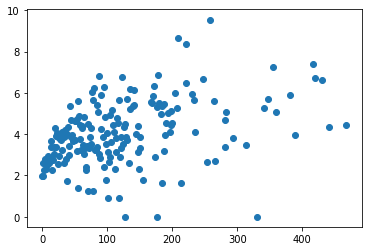

In [30]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
%matplotlib inline

# your code here
# For each node of the followers graph for which we have ground truth information about its influence, 
# add a tuple (influence of node, in-degree of node) to the list  𝑑𝑎𝑡𝑎
# => Create a list of Tuples; Ex list = [ (influence-of-node1, in-degrees-node1), (influence-of-node2, in-degrees-node2) ]
# NB: 'influence-of-node1' contains the number of USER retweeting a tweet for 'user of node1'
data = list()
for node in G.nodes():
    if node in influence :
        data.append((influence[node], G.in_degree(node)))

# Create a scatter plot which illustrates the relationship between influence and in-degree.
df = pd.DataFrame(data, columns=['influence', 'in_degree'])
df = df.groupby('in_degree').mean().reset_index()
plt.scatter(df['in_degree'], df['influence'].apply(np.log))  # in the plot, the y-axis is logarithmic


# your code here
# Calculates a Spearman rank-order correlation coefficient + the p-value to test for non-correlation.
# The Spearman correlation is a nonparametric measure of the monotonicity of the relationship between two datasets
# Unlike the Pearson correlation, the Spearman correlation does not assume that both datasets are normally distributed
# - Positive correlations imply that as x increases, so does y. Negative correlations imply that as x increases, y decreases.
# - The p-value roughly indicates the probability of an uncorrelated system producing datasets 
#   that have a Spearman correlation at least as extreme as the one computed from these datasets.
print(spearmanr(df['influence'], df['in_degree']))  

# https://statistics.laerd.com/statistical-guides/spearmans-rank-order-correlation-statistical-guide.php
# Spearman's correlation determines 
#             the strength and direction of the monotonic relationship between your two variables 
# Rather than the strength and direction of the linear relationship between your two variables, 
# which is what Pearson's correlation determines.


SpearmanrResult(correlation=-0.16409793193355918, pvalue=0.006384067576465413)


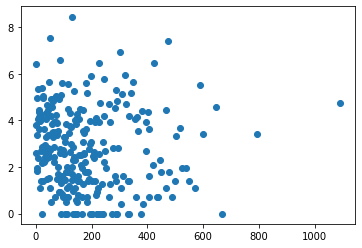

In [31]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
%matplotlib inline

# your code here
# create a list of Tupeles; Ex list = [ (node1, its influence), (node2, its influence) ]
data_out = list()
for node in G.nodes():
    if node in influence :
        data_out.append((influence[node], G.out_degree(node)))

df = pd.DataFrame(data_out, columns=['influence', 'out_degree'])
df = df.groupby('out_degree').mean().reset_index()
plt.scatter(df['out_degree'], df['influence'].apply(np.log))


# your code here
print(spearmanr(df['influence'], df['out_degree']))

We will next investigate how much the core number of a node is related to its influence. The $k$-core structure organizes the graph into nested subgraphs. Specifically, a $k$-core is a maximal subgraph that contains nodes of degree $k$ or more than $k$ within the subgraph. The following Figure illustrates this.

<img src="kcore.png" width="500"/>

This nested partition is easy to compute and many efficient algorithms have been proposed to do this in almost linear time (to the number of edges). The simplest algorithm iterates over the graph repeatedly for each value of $k$ and removes every node that has less than $k$ neighbors. The core number of a node is equal to the highest-order core that this node belongs to. In other words, a node has core number equal to $k$ if it belongs to the $k$-core but not to the $(k+1)$-core.

<u>Tasks</u>:
- Compute the core number of each node. You can use the [`core_number()`](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.core.core_number.html#networkx.algorithms.core.core_number) function of NetworkX.
- For each node of the followers graph for which we have ground truth information about its influence, add a tuple (influence of node, core number of node) to the list $data$.
- Create a scatter plot which illustrates the relationship between influence and core number.
- Compute the relationship between the influence and core number of the nodes using the Spearman correlation.

SpearmanrResult(correlation=0.6394660894660896, pvalue=1.4786086916753327e-07)


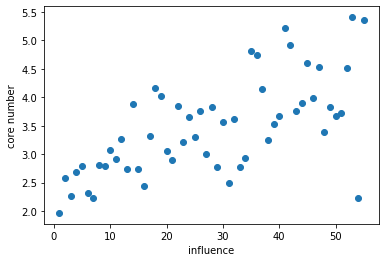

In [34]:
# your code here
core_nums = nx.core_number(G)
# print(core_nums)  # The Core number of User-1 is 29 ... {'1': 29, '3': 40, '4': 55,.....

data = list()
for node in G.nodes():
    if node in influence :
        # influence[node] : number of users influenced by user 'node'
        # core_nums[node] : number of cores (edges) related to to the user 'node'
        data.append((influence[node], core_nums[node]))

df = pd.DataFrame(data, columns=['influence', 'in_degree'])
df = df.groupby('in_degree').mean().reset_index()
plt.scatter(df['in_degree'], df['influence'].apply(np.log))
plt.ylabel('core number')
plt.xlabel('influence')

# your code here
print(spearmanr(df['influence'], df['in_degree']))

# NB: In this case, the correlation is higher thant it was before when using in_degree

### 3. Community Detection
In the second part of the lab, we will focus on the community detection (or clustering) problem in graphs. Typically, a community corresponds to a set of nodes that highly interact among each other, compared to the intensity of interactions (as expressed by the number of edges) with the rest nodes of the graph. The experiments for this part will be performed in the *karate* dataset, a small dataset that has been used as a benchmark in several community detection algorithms. This dataset is a friendship social network between 34 members of a karate club at a US university in the 1970.

<u>Tasks</u>:
- Load the graph using the NetworkX library.
- Print the number of nodes and the number of edges of the network.

Number of Nodes: 34
Number of Edges: 78


C:\envdev\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


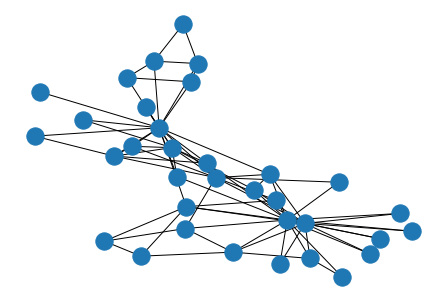

In [36]:
# your code here

import networkx as nx

# your code here
G = nx.read_edgelist("C:\EXED\Training\W6-2\graph_mining_lab\data\karate.edgelist", 
                  comments='#', 
                  delimiter=' ', 
                  create_using=nx.Graph())
print("Number of Nodes:", G.number_of_nodes())
print("Number of Edges:", G.number_of_edges())

nx.draw(G)

We will first implement and apply a very popular graph clustering algorithm, called Spectral Clustering. The basic idea of the algorithm is to utilize information associated to the spectrum of the graph, in order to identify well-separated clusters. The pseudocode of Spectral Clustering is shown below:

1. Let $\mathbf{A}$ be the adjacency matrix of the graph
2. Compute the Laplacian matrix $\mathbf{L} = \mathbf{D}−\mathbf{A}$. Matrix $\mathbf{D}$ corresponds to the diagonal degree matrix of graph $G$ (i.e., degree of each node $v$ (= number of neighbors) in the main diagonal)
3. Apply eigenvalue decomposition to the Laplacian matrix $\mathbf{L}$ and compute the eigenvectors that correspond to $k$ smallest eigenvalues. Let $\mathbf{U} = [\mathbf{u}_1|\mathbf{u}_2| \ldots |\mathbf{u}_k] \in \mathbb{R}^{n \times k}$ be the matrix containing these eigenvectors as columns
4. For $i = 1,\ldots,n$, let $y_i \in \mathbb{R}^k$ be the vector corresponding to the $i$-th row of $\mathbf{U}$. Apply $k$-means to the points $(y_i)_{i=1,\ldots,n}$ (i.e., the rows of $\mathbf{U}$) and find clusters $C_1, C_2, \ldots, C_k$

<u>Tasks</u>:
- Implement the Spectral Clustering algorithm. To perform k-means, you can use scikit-learn's [implementation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) of the algorithm. The Spectral Clustering algorithm must return a dictionary keyed by node to the cluster to which the node belongs.
- After implementing the algorithm, apply it to the `karate` dataset, trying to identify 2 clusters.

In [51]:
from scipy.sparse.linalg import eigs
from sklearn.cluster import KMeans
import networkx as nx

def spectral_clustering(G, k):
    # your code here
    n = G.number_of_nodes()    # get the number of nodes
    A = nx.to_numpy_matrix(G)  # get the adjacency matrix
    D = np.zeros((n,n))        # empty 64*64 matrix. 
    for i in range(n):
        D[i,i] = np.sum(A[i,:])   # set A[i,i] = equals the degree of the ith nodes
    
    L = D - A # Laplacian Matrix
    
    eigvals, eigvecs = eigs(L, k=k, which='SR')   # ‘SR’ : smallest real part. The smallest value will be ZERO for Xi==Xj, this is why we don't retain it
    eigvecs = eigvecs.real  # to retain the real part only (if might be a complex number)
    
    # **NB** When applying KMeans(...) by using the Laplacian L, we retain the 2 smallest EigenValue****
    km=KMeans(n_clusters=k)
    km.fit(eigvecs)
#     print(eigvals)
#     print(eigvecs)
    
    # The Spectral Clustering algorithm must return a dictionary keyed by node to the cluster to which the node belongs.
    clustering = dict()
    for i, node in enumerate(G.nodes()):
        clustering[node] = km.labels_[i] # km.labels_[i] represents the Cluster to which belong the node 'node'
    
    print("clustering : ",clustering)
    return clustering

# your code here
spect_cl_res = spectral_clustering(G,2)

# colors = [spect_cl_res[node] for node in G.nodes()]
# print(colors)
# nx.draw(G, node_color = colors)


clustering :  {'1': 1, '2': 1, '3': 0, '4': 1, '5': 1, '6': 1, '7': 1, '8': 1, '9': 0, '10': 0, '11': 1, '12': 1, '13': 1, '14': 0, '17': 1, '18': 1, '20': 0, '22': 1, '24': 0, '26': 0, '25': 0, '28': 0, '29': 0, '30': 0, '27': 0, '31': 0, '32': 0, '33': 0, '15': 0, '16': 0, '19': 0, '21': 0, '23': 0, '34': 0}


We will next visualize the clustering result.

<u>Task</u>:
- Use the [`draw`](https://networkx.github.io/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw.html#networkx.drawing.nx_pylab.draw) function of NetworkX to visualize the `karate` network. Use the same color for all the nodes belonging to the same cluster.

[1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


C:\envdev\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


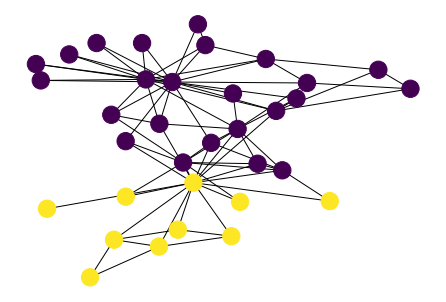

In [43]:
# your code here
colors = [spect_cl_res[node] for node in G.nodes()]

print(colors)
nx.draw(G, node_color = colors)

To assess the quality of a clustering algorithm, several metrics have been proposed. Modularity is one of the most popular and widely used metrics to evaluate the quality of a network's partition into communities. Considering a specific partition of the network into clusters, modularity measures the number of edges that lie within a cluster compared to the expected number of edges of a null graph (or configuration model), i.e., a random graph with the same degree distribution. In other words, the measure of modularity is built upon the idea that random graphs are not expected to present inherent community structure; thus, comparing the observed density of a subgraph with the expected density of the same subgraph in case where edges are placed randomly, leads to a community evaluation metric. Modularity is given by the following formula:
$$ Q = \sum^{n_c} \Bigg[ \frac{l_c}{m} - \Big(\frac{d_c}{2m}\Big)^2\Bigg] $$
where, $m=|E|$ is the total number of edges in the graph, $n_c$ is the number of communities in the graph, $l_c$ is the number of edges within the community $c$ and $d_c$ is the sum of the degrees of the nodes that belong to community $c$. Modularity takes values in the range $[-1, 1]$, with higher values indicating better community structure.

<u>Task</u>:
- Implement a function that given a graph and and an assignment of nodes to clusters, computes the modularity of the clustering result.

In [59]:
def modularity(G, clustering):
    # your code here
    modularity = 0
    m = G.number_of_edges()                                      # total number of edges
    
    clusters = set(clustering.values())
    print("Clusters count :", len(clusters))
    
    for cluster in clusters:
        nodes_in_cluster = [node for node in G.nodes() 
                            if clustering[node] == cluster]
        print(f'Cluster "{cluster}" contains {len(nodes_in_cluster)} nodes : {nodes_in_cluster}')
        subG = G.subgraph(nodes_in_cluster)
        l_c = subG.number_of_edges()                              # number of edges in the cluster
        d_c = sum([G.degree(node) for node in nodes_in_cluster])  # sum of the degrees of the nodes that belong to the cluster
        
        modularity += l_c/m - ( d_c/(2*m))**2
    
    return modularity

In [60]:
modularity(G,spect_cl_res)

Clusters count : 2
Cluster "0" contains 21 nodes : ['3', '9', '10', '14', '20', '24', '26', '25', '28', '29', '30', '27', '31', '32', '33', '15', '16', '19', '21', '23', '34']
Cluster "1" contains 13 nodes : ['1', '2', '4', '5', '6', '7', '8', '11', '12', '13', '17', '18', '22']


0.31328073635765946

Next, we will use modularity to compare the following two clustering results of the `karate` dataset: (i) the one obtained by the Spectral Clustering algorithm, and (ii) the one obtained if we randomly partition the nodes into 2 clusters.
To assign each node to a cluster, use the `randint(a,b)` function which returns a random integer $n$ such that $a \leq n \leq b$.

<u>Tasks</u>:
- Assign the nodes of the `karate` network randomly to 2 clusters to generate a random partitioning of the network.
- Compare the two clustering results. What is the performance of the Spectral Clustering algorithm compared to the algorithm that randomly clusters the nodes?

In [79]:
from random import randint

# your code here
print("Modularity of spectral clustering:", modularity(G,spect_cl_res))

random_cl_res = dict()
for node in G.nodes():
    random_cl_res[node] = randint(0,1)

print("Modularity of random clustering:", modularity(G,random_cl_res))


Modularity of spectral clustering: 0.233974358974359
Modularity of random clustering: -0.07593688362919124


# Graph Classification
In the last part of the lab, we will focus on the problem of graph classification. Graph classification arises in the context of a number of classical domains such as chemical data, biological data, and the web. In order to perform graph classification, we will employ graph kernels, a powerful framework for graph comparison.

Kernels can be intuitively understood as functions measuring the similarity of pairs of objects. More formally, for a function $k(x,x')$ to be a kernel, it has to be (1) symmetric: $k(x,x') = k(x',x)$, and (2) positive semi-definite. If a function satisfies the above two conditions on a set $\mathcal{X}$, it is known that there exists a map $\phi : \mathcal{X} \to \mathcal{H}$ into a Hilbert space $\mathcal{H}$, such that $k(x,x') = \langle \phi(x), \phi(x') \rangle$ for all $(x, x') \in \mathcal{X}^2$ where $\langle\cdot, \cdot\rangle$ is the inner product in $\mathcal{H}$. Kernel functions thus compute the inner product between examples that are mapped in a higher-dimensional feature space. However, they do not necessarily explicitly compute the feature map $\phi$ for each example. One advantage of kernel methods is that they can operate on very general types of data such as images and graphs. Kernels defined on graphs are known as *graph kernels*. Most graph kernels decompose graphs into their substructures and then to measure their similarity, they count the number of common substructures. Graph kernels typically focus on some structural aspect of graphs such as random walks, shortest paths, subtrees, cycles, and graphlets.

We will first create a very simple graph classification dataset. The dataset will contain two types of graphs: (1) cycle graphs, and (2) path graphs. A cycle graph $C_n$ is a graph on $n$ nodes containing a single cycle through all nodes, while a path graph $P_n$ is a tree with two nodes of degree 1, and all the remaining $n-2$ nodes of degree 2. Each graph is assigned a class label: label 0 if it is a cycle or label 1 if it is a path. The Figure below illustrates such a dataset consisting of three cycle graphs and three path graphs.

<img src="synthetic_graphs.png" width="500"/>
    
<u>Task</u>:
- Use the [`cycle_graph()`](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.classic.cycle_graph.html#networkx.generators.classic.cycle_graph) and [`path_graph()`](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.classic.path_graph.html#networkx.generators.classic.path_graph) functions of NetworkX to generate 100 cycle graphs and 100 path graphs of size $n=3,\ldots,102$, respectively. Store the 200 graphs in a list $Gs$ and their class labels in another list $y$.

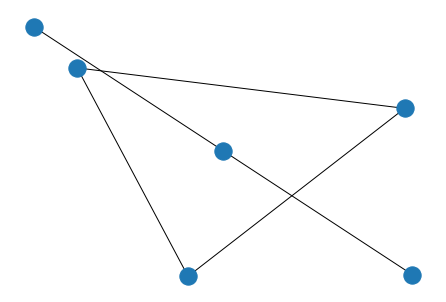

In [63]:
Gs = list()
y = list()

# your code here
for i in range(3,103):  # we begin with 3 bcause we cannot have a cycle if i < 3
    Gs.append(nx.cycle_graph(i))
    y.append(0)
    Gs.append(nx.path_graph(i))
    y.append(1)
    
nx.draw(Gs[0])  # Graphe Cycle
nx.draw(Gs[1])  # Graphe Path

We will next investigate if graph kernels can distinguish cycle graphs from path graphs. To this end, we will make use of the shortest path kernel, a kernel that compares shortest path lengths in two graps. Before computing the kernel, it is necessary to split the dataset into a training and a test set. We can use the [`train_test_split()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function of scikit-learn as follows:
    
    from sklearn.model_selection import train_test_split

    G_train, G_test, y_train, y_test = train_test_split(Gs, y, test_size=0.1)
    
<u>Task</u>:
- Split the dataset into a training and a test set.

In [66]:
from sklearn.model_selection import train_test_split

# your code here
G_train, G_test, y_train, y_test = train_test_split(Gs, y, test_size=0.1)

The shortest path kernel compares the length of shortest paths of two graphs. More specifically, given two graphs $G=(V,E)$ and $G'=(V',E')$, the shortest path kernel is defined as:

$$
k(G,G') = \sum_{(v_1,v_2) \in V \times V} \sum_{(v'_1,v'_2) \in V' \times V'} k_{length}(sp_{v_1,v_2}, sp_{v'_1,v'_2})
$$

where $k_{length}$ is a kernel on shortest path lengths, and $sp_{v_i,v_j}$ is the length of the shortest path between vertices $v_i$ and $v_j$. We will use the following kernel for comparing shortest path lengths:

$$
k_{length}(sp_{v_1,v_2}, sp_{v'_1,v'_2}) = \left\{
            \begin{array}{lr}
                1 & \text{if }sp_{v_1,v_2} = sp_{v'_1,v'_2},\\
                0 & \text{otherwise}
            \end{array}
            \right.
$$

Therefore, $k_{length}(sp_{v_1,v_2}, sp_{v'_1,v'_2})$ is equal to 1 if $sp_{v_1,v_2}$ and $sp_{v'_1,v'_2}$ are equal to each other, and $0$ otherwise.

Below you are given a function that takes as input two sets of graphs (of sizes $N_1$ and $N_2$), and computes the kernel matrix $K \in \mathbb{R}^{N_1\times N_2}$ which stores the kernel values between the graphs of the first set and those of the second set.

In [78]:
def sp_kernel(Gs1, Gs2):
    N1 = len(Gs1) # Graphe count in Gs1
    N2 = len(Gs2) # Graphe count in Gs2
    
    all_paths = dict() # all_paths = {0: 0, 1: 1, 2: 2, 3: 3, ..., 100: 100, 101: 101}
    sp_counts = dict() # sp_count = { graph_0:{path_length_n:count_n, path_length_m:count_m, ...}, graph_1:{}, graph_2:{}, .... }
    
    # Gs1 is a list containing either Cycle-Graph or Path-Graph 
    # => G is either Cycle-Graph or Path-Graph & 'i' the index order of the Graph in Gs
    for i,G in enumerate(Gs1):  
        
        # sp_lengths is a 'dict' initialized by nx.shortest_path_length(G)
        # As we didn't set 'source' and 'target', then nx.shortest_path_length(G) will compute all the paths 
        # resulting from the combination of all nodes as 'source' and as 'target'
        sp_lengths = dict(nx.shortest_path_length(G)) 
        # print("sp_lengths :", sp_lengths) # =>  { 0:{0: 0, 1: 1, 2: 2, ...}, 1:{1: 0, 0: 1, 2: 1, 3: 2 ...}, 2:{....}   }
        
        sp_counts[i] = dict()  
        nodes = G.nodes()
        for v1 in nodes:
            for v2 in nodes:
                if v2 in sp_lengths[v1]:
                    length = sp_lengths[v1][v2]    # the length between the nodes 'v1' and 'v2'
                    if length in sp_counts[i]:
                        sp_counts[i][length] += 1  # increment the count related to path of length 'length' for the Graph 'i'
                    else:
                        sp_counts[i][length] = 1

                    if length not in all_paths:
                        all_paths[length] = len(all_paths)
                        # print("all_paths :",all_paths)
                        
    for i,G in enumerate(Gs2):
        sp_lengths = dict(nx.shortest_path_length(G))
        sp_counts[N1+i] = dict()
        nodes = G.nodes()
        for v1 in nodes:
            for v2 in nodes:
                if v2 in sp_lengths[v1]:
                    length = sp_lengths[v1][v2]
                    if length in sp_counts[N1+i]:
                        sp_counts[N1+i][length] += 1
                    else:
                        sp_counts[N1+i][length] = 1

                    if length not in all_paths:
                        all_paths[length] = len(all_paths)

    phi1 = np.zeros( (N1,len(all_paths)) )   # N1: Graphe count in Gs1
    for i in range(N1):
        for length in sp_counts[i]:
            phi1[i,all_paths[length]] = sp_counts[i][length]
    # print("phi1.shape :", phi1.shape) # (180, 102) => 108 Graphes in Gs1  & 102 longueur de path 
    # print("phi1:", phi1)        
    
    phi2 = np.zeros( (N2,len(all_paths)) )   # N2: Graphe count in Gs2
    for i in range(N2):
        for length in sp_counts[N1+i]:
            phi2[i,all_paths[length]] = sp_counts[N1+i][length]

    K = np.dot(phi1,phi2.T)

    return K

In [79]:
sp_kernel(G_train, G_train)

array([[  3472.,  20412.,  32200., ...,  19278.,  17080.,  21994.],
       [ 20412., 309096., 441288., ..., 278154., 210168., 285282.],
       [ 32200., 441288., 963960., ..., 397290., 362200., 542094.],
       ...,
       [ 19278., 278154., 397290., ..., 262701., 191250., 258213.],
       [ 17080., 210168., 362200., ..., 191250., 164200., 228550.],
       [ 21994., 285282., 542094., ..., 258213., 228550., 329469.]])

We are interested in generating two matrices. A symmetric matrix $\mathbf{K}_{train}$ which contains the kernel values for all pairs of training graphs, and a second matrix $\mathbf{K}_{test}$ which stores the kernel values between the graphs of the test set and those of the training set. We can obtain these two matrices very easily using the function defined above. After generating the two kernel matrices, we can use the SVM classifier to perform graph classification.

<u>Tasks</u>:
- Use the shortest path kernel to compute the $\mathbf{K}_{train}$ and $\mathbf{K}_{test}$ matrices.
- Train an [SVM classifier](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) and use it to make predictions. Note that we have already pre-computed the kernel matrices (set parameter kernel equal to 'precomputed').  

In [80]:
from sklearn.svm import SVC

# your code here
K_train = sp_kernel(G_train, G_train)
print(K_train.shape)  # (180,180)

K_test = sp_kernel(G_test, G_train)  # we need to compare the Test Graph against the Train Graph
print(K_test.shape)  # (20,180)

# Then use the SVM classifier
clf = SVC(kernel = 'precomputed')  # bcause we already commputed the kernel

clf.fit(K_train, y_train)
y_pred = clf.predict(K_test)

(180, 180)
(20, 180)


Finally, we will evaluate the shortest path kernel. More specifically, we will compute its classification accuracy.

<u>Tasks</u>:
- Use the [`accuracy_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) function of scikit-learn to compute the classification accuracy of the shortest path kernel. 

In [81]:
from sklearn.metrics import accuracy_score

# your code here
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 1.0


In [ ]:
# NB: We could have used the python library GraKel instead applying the above processing